In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import os

In [3]:
def my_seed_everywhere(seed: int = 42):
    random.seed(seed) # random
    np.random.seed(seed) # np
    os.environ["PYTHONHASHSEED"] = str(seed) # os
    tf.random.set_seed(seed) # tensorflow

my_seed = 42
my_seed_everywhere(my_seed)

In [4]:
df = pd.read_csv('/content/sample_data/onion_final.csv', index_col=0)
df = df.dropna(axis=0)
df = df.reset_index(drop=True)
df['Date'] = pd.to_datetime(df['Date'])
df['DayOfWeek'] = df['Date'].dt.dayofweek

In [5]:
df = df.drop(['Temp'],axis=1)
df = df.drop(['Oil'],axis=1)
df = df.drop(['Sup'],axis=1)
df = df.drop(['Avg_Price'], axis=1)

df['DayOfWeek'] = df['DayOfWeek'].astype('category')
df = pd.get_dummies(df, columns =['DayOfWeek'], prefix='W', drop_first=True)

df.tail()

,Date,Rain,Wind,sobimul,nongmul,Price,Produced,W_1,W_2,W_3,W_4
2390,2022-09-26,0.0,1.7,2.5,8.7,2601.0,1576752,0,0,0,0
2391,2022-09-27,0.0,1.6,2.5,8.7,2601.0,1576752,1,0,0,0
2392,2022-09-28,0.0,1.8,2.5,8.7,2601.0,1576752,0,1,0,0
2393,2022-09-29,0.0,1.4,2.5,8.7,2480.0,1576752,0,0,1,0
2394,2022-09-30,0.0,1.6,2.5,8.7,2480.0,1576752,0,0,0,1


In [6]:
from sklearn.preprocessing import MinMaxScaler
input_indicator = df.loc[:,['Rain', 'Wind', 'sobimul', 'nongmul', 'Produced', 'W_1', 'W_2', 'W_3', 'W_4']]
target_indicator = df.loc[:,['Price']].values[:]

scaler_input = MinMaxScaler()
scaler_target = MinMaxScaler()
scaled_input_indicator = scaler_input.fit_transform(input_indicator)
scaled_target_indicator = scaler_target.fit_transform(target_indicator) # 가격 관련 지표에 스케일링

x = np.concatenate((scaled_target_indicator, scaled_input_indicator), axis=1)
y = x[:, [0]]

print(x)
print(y.shape)

[[0.37931034 0.         0.61403509 ... 1.         0.         0.        ]
 [0.35632184 0.         0.36842105 ... 0.         1.         0.        ]
 [0.35632184 0.         0.19298246 ... 0.         0.         1.        ]
 ...
 [0.52576937 0.         0.19298246 ... 1.         0.         0.        ]
 [0.48090471 0.         0.12280702 ... 0.         1.         0.        ]
 [0.48090471 0.         0.15789474 ... 0.         0.         1.        ]]
(2395, 1)


In [7]:
# 21일치의 input으로 8일치의 output을 생산(API 문제상 당일날 input은 활용 불가능할 것으로 예상됨)
# 추후 train, validation, train set를 6년, 2년, 2년으로 나눠볼까 생각중, 지금은 many_to_many 코드 구현을 목표로 구현하지 않음
seq_length = 3
predict_day = 3
dataX = [] 
dataY = [] 
for i in range(0, int(len(y) - seq_length - predict_day)):
    _x = x[i : i + seq_length]
    _y = y[i + predict_day : i + seq_length + predict_day] 
    dataX.append(_x) 
    dataY.append(_y) 
print(len(dataX))
print(len(dataY))

2389
2389


In [8]:
# Train Set 생성, 추후 Validation, Test도 여기에다가 추가 예상됨, 또한 21의 배수로 설정해야 batch에서 오류가 발생하지 않음
train_size = 1431
validation_size = 477
test_size = 477

trainX = np.array(dataX[0:train_size])
trainY = np.array(dataY[0:train_size])
validX = np.array(dataX[train_size:train_size+validation_size])
validY = np.array(dataY[train_size:train_size+validation_size])
testX = np.array(dataX[train_size+validation_size:train_size+validation_size+test_size])
testY = np.array(dataY[train_size+validation_size:train_size+validation_size+test_size])

print(trainX.shape)
print(trainY.shape)
print(validX.shape)
print(validY.shape)
print(testX.shape)
print(testY.shape)

(1431, 3, 10)
(1431, 3, 1)
(477, 3, 10)
(477, 3, 1)
(477, 3, 10)
(477, 3, 1)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Activation
from tensorflow import keras

In [10]:
class CustomHistory(keras.callbacks.Callback):
    def init(self):
        self.train_loss = []
        self.val_loss = []
        
    def on_epoch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

In [11]:
input_columns = 10 # 데이터 셋의 '열' 개수 (dataX) / dataset's columns (dataX)

model = Sequential()
model.add(LSTM(16, batch_input_shape=(3, 3, input_columns), return_sequences=True, stateful=True, dropout=0.1))
model.add(LSTM(16, return_sequences=True, stateful=True, dropout=0.1))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (3, 3, 16)                1728      
                                                                 
 lstm_1 (LSTM)               (3, 3, 16)                2112      
                                                                 
 dense (Dense)               (3, 3, 1)                 17        
                                                                 
Total params: 3,857
Trainable params: 3,857
Non-trainable params: 0
_________________________________________________________________


In [12]:
from tensorflow.keras.callbacks import EarlyStopping
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model-potato.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)

In [13]:
keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [14]:
custom_hist = CustomHistory()
custom_hist.init()

In [15]:
for epoch_idx in range(100):
  print('epochs:' + str(epoch_idx))
  hist = model.fit(trainX, trainY, validation_data=(validX, validY), epochs=1, batch_size=3, verbose=2, shuffle=False, callbacks=[checkpoint_cb, custom_hist, early_stopping_cb])
  model.reset_states()

epochs:0
477/477 - 11s - loss: 0.0216 - mae: 0.0959 - val_loss: 0.0128 - val_mae: 0.0964 - 11s/epoch - 23ms/step
epochs:1
477/477 - 2s - loss: 0.0215 - mae: 0.1004 - val_loss: 0.0133 - val_mae: 0.0987 - 2s/epoch - 5ms/step
epochs:2
477/477 - 2s - loss: 0.0230 - mae: 0.1065 - val_loss: 0.0157 - val_mae: 0.1039 - 2s/epoch - 5ms/step
epochs:3
477/477 - 2s - loss: 0.0214 - mae: 0.1064 - val_loss: 0.0253 - val_mae: 0.1335 - 2s/epoch - 4ms/step
epochs:4
477/477 - 2s - loss: 0.0175 - mae: 0.0934 - val_loss: 0.0349 - val_mae: 0.1648 - 2s/epoch - 4ms/step
epochs:5
477/477 - 2s - loss: 0.0137 - mae: 0.0812 - val_loss: 0.0403 - val_mae: 0.1846 - 2s/epoch - 4ms/step
epochs:6
477/477 - 2s - loss: 0.0116 - mae: 0.0742 - val_loss: 0.0329 - val_mae: 0.1684 - 2s/epoch - 5ms/step
epochs:7
477/477 - 2s - loss: 0.0098 - mae: 0.0680 - val_loss: 0.0304 - val_mae: 0.1634 - 2s/epoch - 5ms/step
epochs:8
477/477 - 2s - loss: 0.0081 - mae: 0.0617 - val_loss: 0.0241 - val_mae: 0.1451 - 2s/epoch - 4ms/step
epochs:

In [16]:
a = 3

In [17]:
model.evaluate(trainX, trainY, batch_size = a)

477/477 [==============================] - 1s 3ms/step - loss: 0.0024 - mae: 0.0384


[0.002407992724329233, 0.03838789835572243]

In [18]:
print(custom_hist.train_loss)

[0.02159246988594532, 0.021465377882122993, 0.02297699823975563, 0.021363185718655586, 0.017476603388786316, 0.013735751621425152, 0.011607600376009941, 0.009761247783899307, 0.008055727928876877, 0.008141621015965939, 0.00670455489307642, 0.00629656296223402, 0.005942962598055601, 0.005587480962276459, 0.00568412896245718, 0.005360312294214964, 0.005141012836247683, 0.004965243395417929, 0.0047151860781013966, 0.004675738513469696, 0.005032464861869812, 0.004239034838974476, 0.00429970258846879, 0.004379849880933762, 0.003853562055155635, 0.004081784747540951, 0.003712279489263892, 0.0037133386358618736, 0.003637181594967842, 0.0033062719739973545, 0.003676327411085367, 0.003816830925643444, 0.003419999498873949, 0.0033403236884623766, 0.002760721603408456, 0.0029384831432253122, 0.0030204071663320065, 0.002513136016204953, 0.00253470940515399, 0.00232996535487473, 0.002457977971062064, 0.002189141232520342, 0.0023203955497592688, 0.002056862460449338, 0.0021809523459523916, 0.0024203

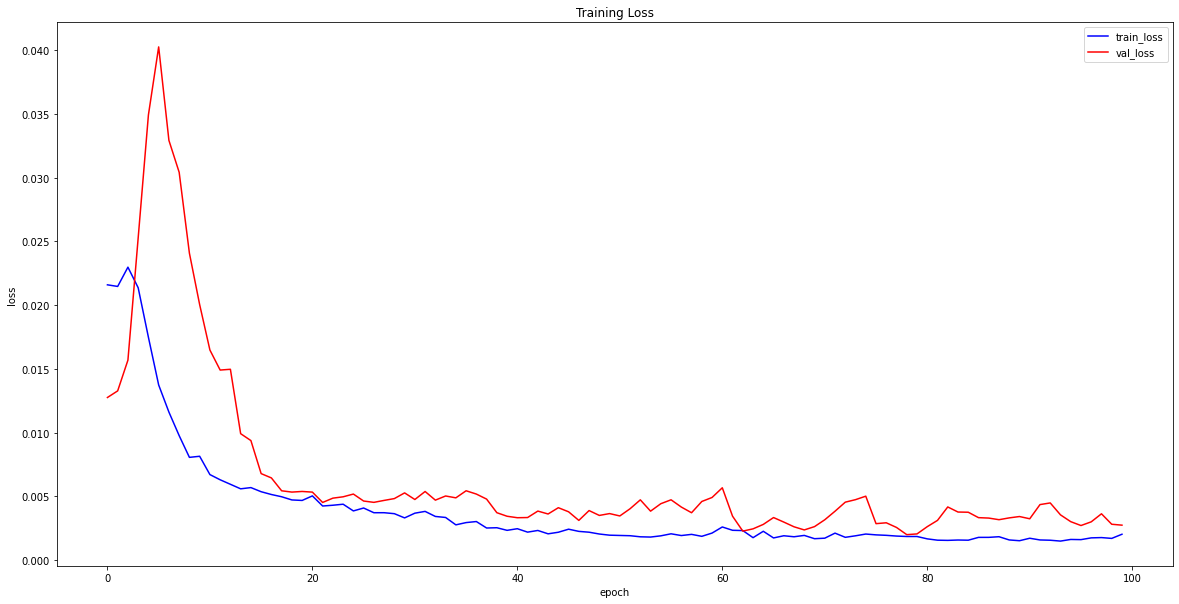

In [19]:
plt.figure(figsize=(20,10))
plt.plot(custom_hist.train_loss, color = 'blue', label = 'train_loss')
plt.plot(custom_hist.val_loss, color = 'red', label = 'val_loss')
plt.title('Training Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [20]:
from keras.models import load_model
model = load_model('/content/best-model-potato.h5')

Train Data *평가*

In [21]:
model.evaluate(trainX, trainY, batch_size=a)

477/477 [==============================] - 2s 3ms/step - loss: 0.0038 - mae: 0.0480


[0.003835893701761961, 0.048017390072345734]

In [22]:
predicted_price_train = model.predict(trainX, batch_size=a, verbose=1) 

477/477 [==============================] - 3s 4ms/step


In [24]:
trainY_test = np.delete(trainY, np.s_[1:a], axis=1)
predicted_price_train_test = np.delete(predicted_price_train, np.s_[1:a], axis=1)

trainY_test = np.reshape(trainY_test, (1431, 1))
predicted_price_train_test = np.reshape(predicted_price_train_test, (1431, 1))
print(trainY_test.shape)
print(predicted_price_train_test.shape)

(1431, 1)
(1431, 1)


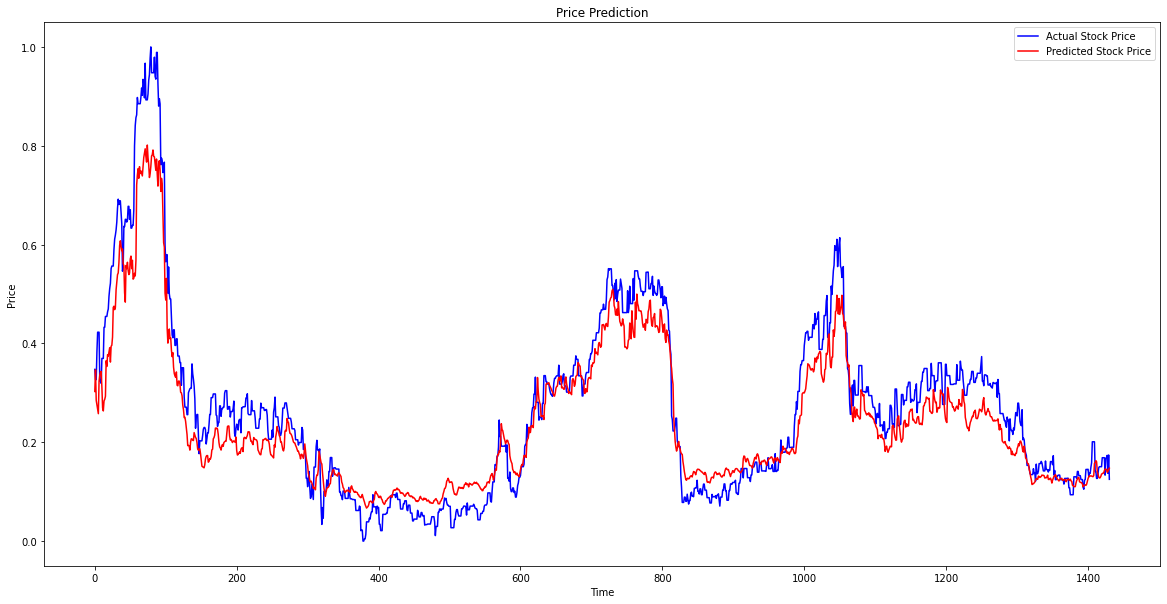

In [25]:
plt.figure(figsize=(20,10))
plt.plot(trainY_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price_train_test, color = 'red', label = 'Predicted Stock Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [26]:
predicted_price_train_test = np.reshape(predicted_price_train_test, (1431, ))
predicted_price_train_test = scaler_target.inverse_transform(predicted_price_train_test.reshape(-1,1))

print(predicted_price_train_test, predicted_price_train_test.shape)

trainY_test = scaler_target.inverse_transform(trainY_test.reshape(-1,1))

print(trainY_test, trainY_test.shape)

[[1999.5363]
 [2117.5737]
 [1951.1188]
 ...
 [1563.4185]
 [1574.9076]
 [1580.828 ]] (1431, 1)
[[2120.]
 [2064.]
 [2064.]
 ...
 [1553.]
 [1653.]
 [1520.]] (1431, 1)


In [27]:
from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(trainY_test, predicted_price_train_test) 
np.sqrt(MSE)

166.45820062472242

In [28]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(trainY_test, predicted_price_train_test)

129.20575143106328

Val Date 평가


In [29]:
model.evaluate(validX, validY, batch_size=a)

159/159 [==============================] - 0s 3ms/step - loss: 0.0020 - mae: 0.0330


[0.0019915953744202852, 0.03300829976797104]

In [30]:
predicted_price_valid = model.predict(validX, batch_size=a, verbose=1) 

159/159 [==============================] - 0s 2ms/step


(477, 1)
(477, 1)


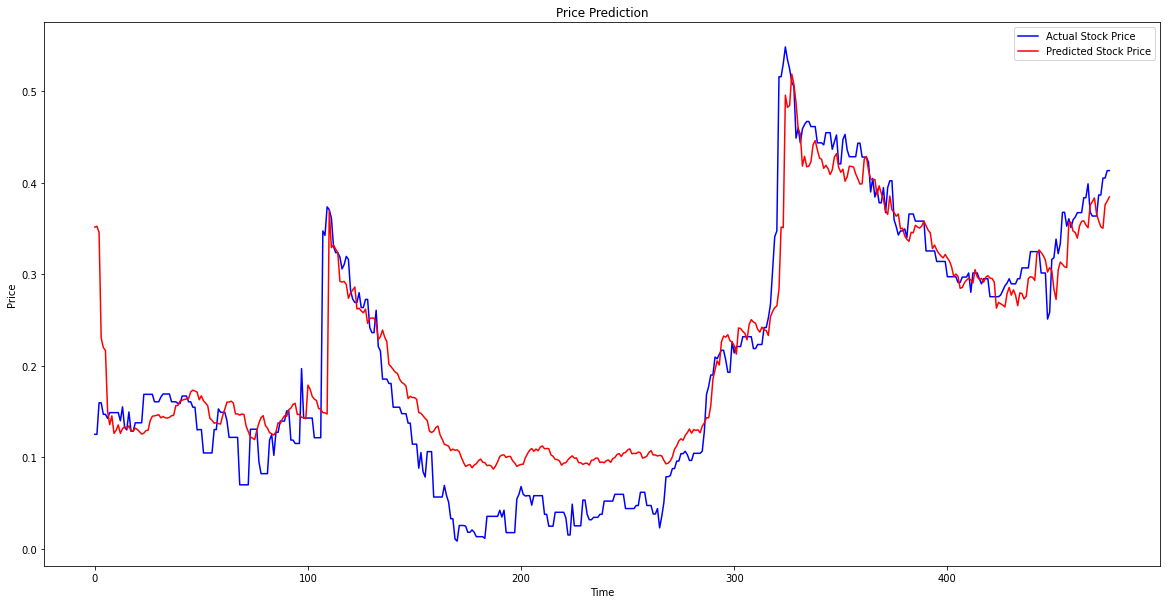

In [31]:
validY_test = np.delete(validY, np.s_[1:a], axis=1)
predicted_price_valid_test = np.delete(predicted_price_valid, np.s_[1:a], axis=1)

validY_test = np.reshape(validY_test, (477, 1))
predicted_price_valid_test = np.reshape(predicted_price_valid_test, (477, 1))
print(validY_test.shape)
print(predicted_price_valid_test.shape)

plt.figure(figsize=(20,10))
plt.plot(validY_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price_valid_test, color = 'red', label = 'Predicted Stock Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [32]:
predicted_price_valid_test = np.reshape(predicted_price_valid_test, (477, ))
predicted_price_valid_test = scaler_target.inverse_transform(predicted_price_valid_test.reshape(-1,1))

print(predicted_price_valid_test, predicted_price_valid_test.shape)

validY_test = scaler_target.inverse_transform(validY_test.reshape(-1,1))

print(validY_test, validY_test.shape)

[[2131.4438]
 [2133.7417]
 [2115.8962]
 [1803.4865]
 [1776.1208]
 [1767.2344]
 [1587.8597]
 [1548.436 ]
 [1574.4219]
 [1522.8448]
 [1531.5457]
 [1547.7661]
 [1522.7373]
 [1536.5587]
 [1542.5604]
 [1537.3921]
 [1545.0266]
 [1529.184 ]
 [1529.6165]
 [1538.3351]
 [1534.0905]
 [1527.5184]
 [1520.6825]
 [1523.5085]
 [1530.9036]
 [1532.2225]
 [1560.4004]
 [1573.2059]
 [1574.4817]
 [1575.9768]
 [1578.0817]
 [1568.6487]
 [1572.6636]
 [1568.9241]
 [1567.9203]
 [1570.1156]
 [1574.847 ]
 [1576.2441]
 [1604.5132]
 [1605.6105]
 [1617.8588]
 [1620.6321]
 [1623.0857]
 [1623.9948]
 [1625.4438]
 [1645.171 ]
 [1650.3529]
 [1647.7561]
 [1644.4506]
 [1621.9852]
 [1633.6647]
 [1618.8071]
 [1611.9131]
 [1604.1184]
 [1567.111 ]
 [1561.3916]
 [1552.945 ]
 [1554.139 ]
 [1551.8496]
 [1550.3967]
 [1575.2599]
 [1594.4519]
 [1614.7958]
 [1615.1179]
 [1617.7708]
 [1612.3167]
 [1580.2203]
 [1580.2085]
 [1576.5825]
 [1580.0474]
 [1578.3011]
 [1544.043 ]
 [1528.5261]
 [1512.1456]
 [1508.8004]
 [1504.3096]
 [1531.933 ]

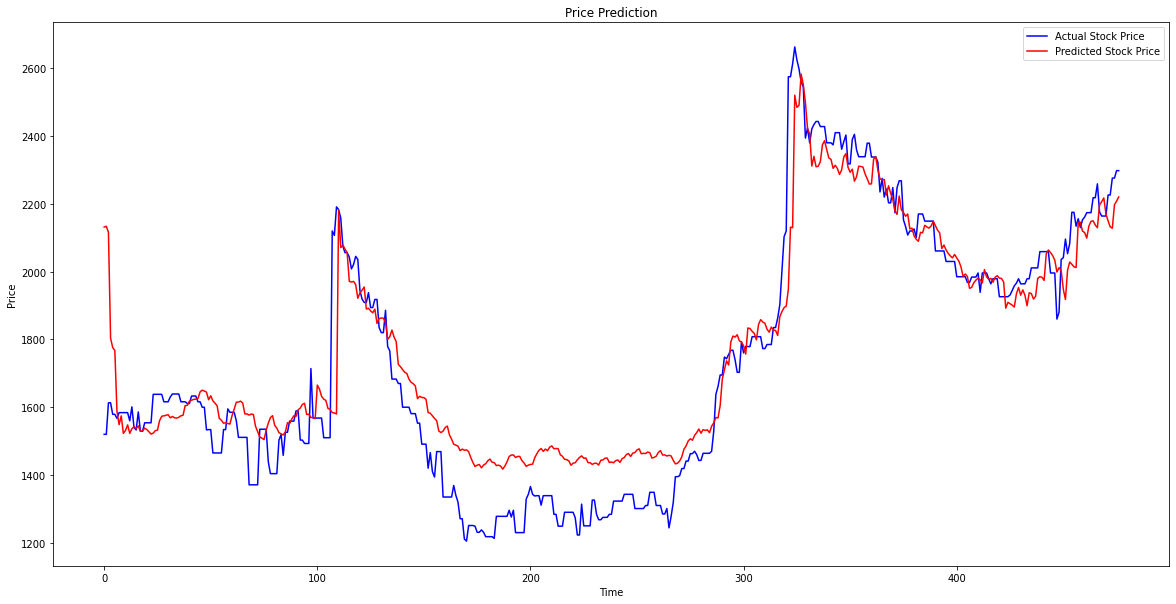

In [33]:
plt.figure(figsize=(20,10))
plt.plot(validY_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price_valid_test, color = 'red', label = 'Predicted Stock Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [34]:
from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(validY_test, predicted_price_valid_test) 
np.sqrt(MSE)

129.40760005842478

In [35]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(validY_test, predicted_price_valid_test)

92.77344876015461

Test Data 평가

In [36]:
model.evaluate(testX, testY, batch_size=a)

159/159 [==============================] - 0s 3ms/step - loss: 0.0095 - mae: 0.0747


[0.009484954178333282, 0.07468622177839279]

In [37]:
predicted_price_test = model.predict(testX, batch_size=a, verbose=1)

159/159 [==============================] - 0s 2ms/step


(477, 1)
(477, 1)


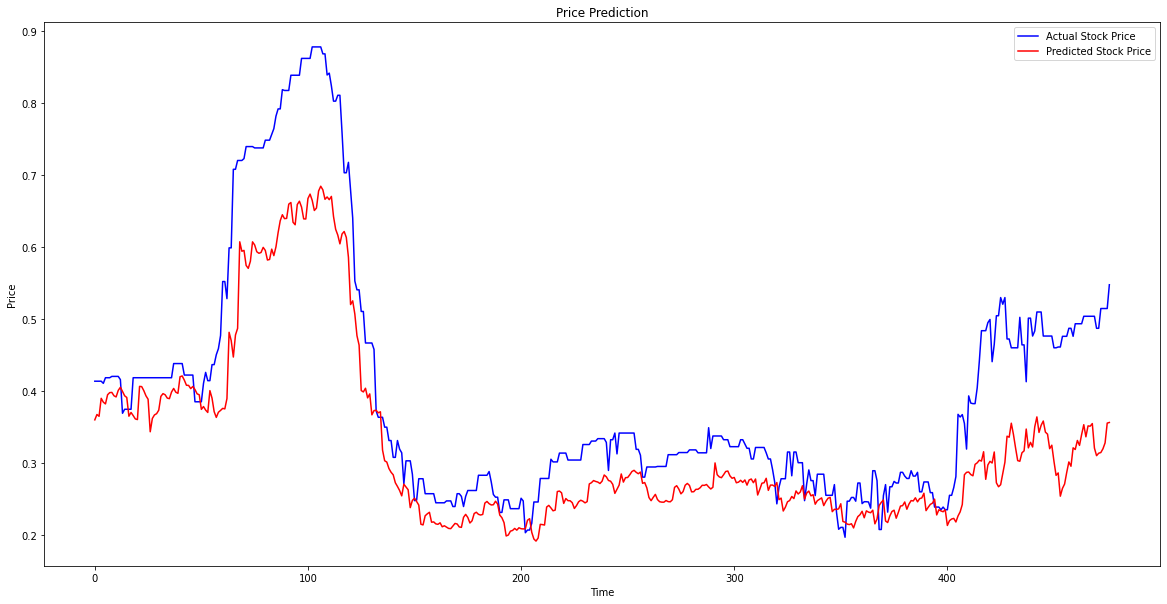

In [39]:
testY_test = np.delete(testY, np.s_[1:a], axis=1)
predicted_price_test_test = np.delete(predicted_price_test, np.s_[1:a], axis=1)

testY_test = np.reshape(testY_test, (477, 1))
predicted_price_test_test = np.reshape(predicted_price_test_test, (477, 1))
print(testY_test.shape)
print(predicted_price_test_test.shape)

plt.figure(figsize=(20,10))
plt.plot(testY_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price_test_test, color = 'red', label = 'Predicted Stock Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [40]:
predicted_price_test_test = np.reshape(predicted_price_test_test, (477, ))
predicted_price_test_test = scaler_target.inverse_transform(predicted_price_test_test.reshape(-1,1))

print(predicted_price_test_test, predicted_price_test_test.shape)

testY_test = scaler_target.inverse_transform(testY_test.reshape(-1,1))

print(testY_test, testY_test.shape)

[[2153.3328]
 [2173.3755]
 [2166.5923]
 [2233.976 ]
 [2219.6128]
 [2212.9805]
 [2247.3848]
 [2255.3062]
 [2256.0403]
 [2243.4995]
 [2239.168 ]
 [2263.6614]
 [2275.1187]
 [2259.7534]
 [2243.454 ]
 [2237.0962]
 [2167.0234]
 [2180.976 ]
 [2169.4595]
 [2156.8904]
 [2154.3945]
 [2278.6091]
 [2277.8174]
 [2262.4924]
 [2243.3887]
 [2230.4656]
 [2108.7578]
 [2158.5278]
 [2171.8577]
 [2176.4795]
 [2189.5415]
 [2241.2935]
 [2251.516 ]
 [2247.3071]
 [2234.7961]
 [2232.7153]
 [2257.5125]
 [2270.9934]
 [2256.9238]
 [2252.5803]
 [2314.7068]
 [2317.7068]
 [2301.9722]
 [2282.8025]
 [2282.327 ]
 [2270.2615]
 [2278.3142]
 [2266.6785]
 [2250.798 ]
 [2247.2273]
 [2192.664 ]
 [2203.2156]
 [2189.9543]
 [2181.005 ]
 [2262.7644]
 [2234.5374]
 [2183.9973]
 [2162.507 ]
 [2181.8977]
 [2188.6826]
 [2196.3445]
 [2194.4133]
 [2233.0503]
 [2480.9753]
 [2449.92  ]
 [2388.4233]
 [2471.0286]
 [2495.7986]
 [2819.6912]
 [2784.3093]
 [2787.4668]
 [2731.1775]
 [2720.3096]
 [2747.069 ]
 [2819.5474]
 [2807.8442]
 [2782.4468]

In [41]:
from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(testY_test, predicted_price_test_test) 
np.sqrt(MSE)

262.1562226588836

In [42]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(testY_test, predicted_price_test_test)

201.31259494357639

예측방법

In [43]:
minX1 = np.array(dataX[0:3])
minX2 = np.array(dataX[0:4])
minX3 = np.array(dataX[0:2385])
minX4 = np.array(dataX[0:train_size])

In [44]:
predicted_price_min1 = model.predict(minX1, batch_size=a, verbose=1)
predicted_price_min2 = model.predict(minX2, batch_size=a, verbose=1) 
predicted_price_min3 = model.predict(minX3, batch_size=a, verbose=1)
predicted_price_min4 = model.predict(minX4, batch_size=a, verbose=1) 

477/477 [==============================] - 1s 3ms/step


In [45]:
predicted_price_min1[0]

array([[0.33595017],
       [0.28205067],
       [0.27841485]], dtype=float32)

In [46]:
predicted_price_min2[0]

array([[0.29468322],
       [0.2786926 ],
       [0.2798767 ]], dtype=float32)

In [47]:
predicted_price_min3[0]

array([[0.2916658 ],
       [0.28503513],
       [0.28518355]], dtype=float32)

In [48]:
scaler_target.inverse_transform(predicted_price_min4[0].reshape(-1,1))

array([[2089.0576],
       [1943.6907],
       [1933.8849]], dtype=float32)